In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('dark')
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import os
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Importing dataset
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# Load the data
data = pd.read_csv("/kaggle/input/titanic/train.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Exploring the data

In [3]:
# Display the dimensions of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Fields and data types 🗒️:
| Variable | Definition                          | Key                                      |
|----------|------------------------------------ |------------------------------------------|
| survival | Survival                            | 0 = No, 1 = Yes                          |
| pclass   | Ticket class                        | 1 = 1st, 2 = 2nd, 3 = 3rd               |
| sex      | Sex                                 |                                          |
| Age      | Age in years                        |                                          |
| sibsp    | # of siblings / spouses aboard the Titanic |                                      |
| parch    | # of parents / children aboard the Titanic |                                      |
| ticket   | Ticket number                       |                                          |
| fare     | Passenger fare                      |                                          |
| cabin    | Cabin number                        |                                          |
| embarked | Port of Embarkation                 | C = Cherbourg, Q = Queenstown, S = Southampton |


X = strat_train_set.drop(["Survived"], axis=1)  # Extract features from preprocessed training set
y = strat_train_set["Survived"]  # Extract target variable from preprocessed training set

scaler = StandardScaler()  # Initialize StandardScaler object
X_data = scaler.fit_transform(X)  # Standardize features
y_data = y.to_numpy()  # Convert target variable to NumPy array# My analysis:
## Interesting dataset, the Age have missing data.

In [4]:
# Display the dimensions of the dataset
data.shape

(891, 12)

In [5]:
# Display descriptive statistics of the dataset
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Display column names of the dataset
data.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [7]:
# Count the ocurrences of each Sex in the dataset
data.Sex.value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [8]:
# Count the ocurrences of each Pclass in the dataset
data.Pclass.value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [9]:
# Count how many people survived
data.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

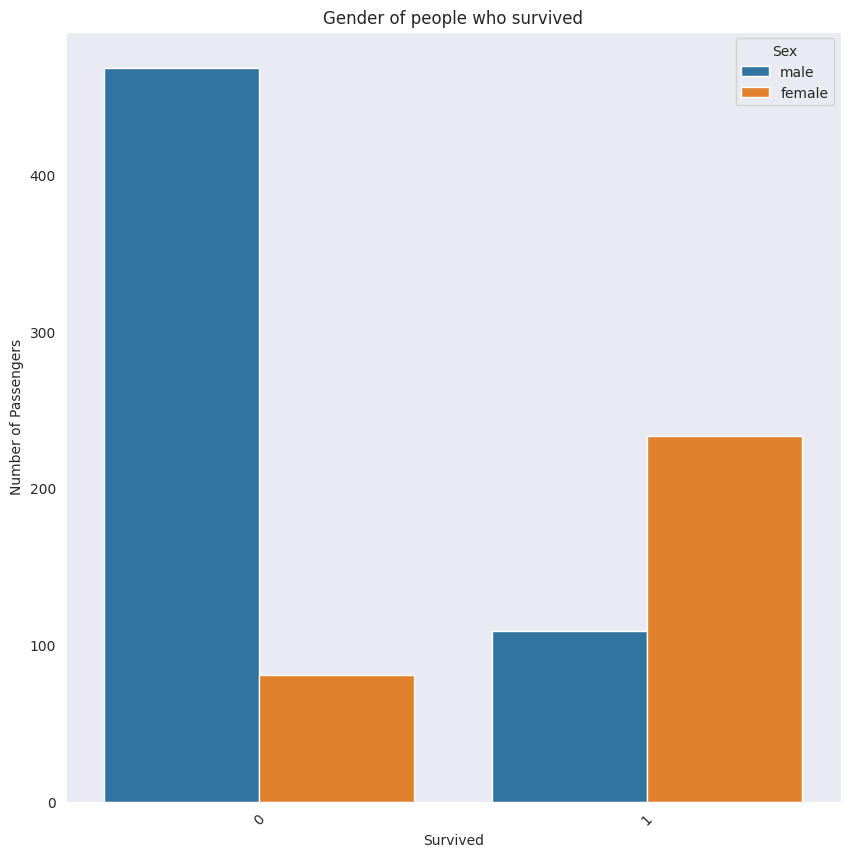

In [10]:
plt.figure(figsize=(10,10))
# Create a countplot of the data, ordering the bars by the count of games in each genre
sns.countplot(x="Survived", hue="Sex", data=data)  # Specify hue parameter to differentiate by sex
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
# Label the x and y axes
plt.xlabel('Survived')  # Change x-axis label to represent survival status
plt.ylabel('Number of Passengers')
plt.title('Gender of people who survived')
plt.show()

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(data, data[["Survived","Pclass","Sex"]]):
    # Iterate through splits
    strat_train_set = data.loc[train_indices]
    strat_test_set = data.loc[test_indices]

In [12]:
strat_test_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
363,364,0,3,"Asim, Mr. Adola",male,35.0,0,0,SOTON/O.Q. 3101310,7.0500,NaN,S
595,596,0,3,"Van Impe, Mr. Jean Baptiste",male,36.0,1,1,345773,24.1500,NaN,S
288,289,1,2,"Hosono, Mr. Masabumi",male,42.0,0,0,237798,13.0000,NaN,S
560,561,0,3,"Morrow, Mr. Thomas Rowan",male,NaN,0,0,372622,7.7500,NaN,Q
127,128,1,3,"Madsen, Mr. Fridtjof Arne",male,24.0,0,0,C 17369,7.1417,NaN,S


In [13]:
strat_train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
408,409,0,3,"Birkeland, Mr. Hans Martin Monsen",male,21.0,0,0,312992,7.7750,NaN,S
624,625,0,3,"Bowen, Mr. David John ""Dai""",male,21.0,0,0,54636,16.1000,NaN,S
707,708,1,1,"Calderhead, Mr. Edward Pennington",male,42.0,0,0,PC 17476,26.2875,E24,S
858,859,1,3,"Baclini, Mrs. Solomon (Latifa Qurban)",female,24.0,0,3,2666,19.2583,NaN,C
594,595,0,2,"Chapman, Mr. John Henry",male,37.0,1,0,SC/AH 29037,26.0000,NaN,S


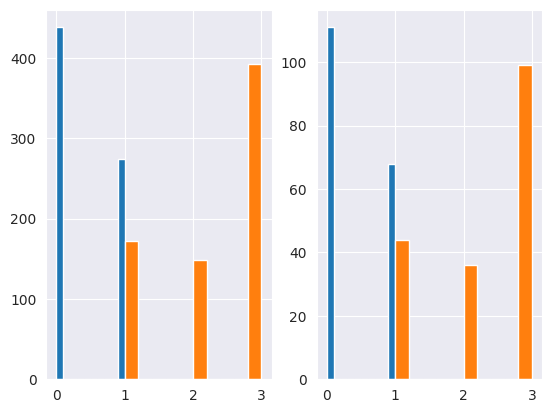

In [14]:
# Create subplot
plt.subplot(1,2,1)
# Create histogram for Survived column in training set
strat_train_set["Survived"].hist()
# Create histogram for Pclass column in training set
strat_train_set["Pclass"].hist() 

# Create subplot
plt.subplot(1,2,2)
# Create histogram for Survived column in test set
strat_test_set["Survived"].hist()  
# Create histogram for Pclass column in test set
strat_test_set["Pclass"].hist()  

plt.show()

In [15]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 408 to 143
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          574 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        164 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [16]:
# Define custom transformer for imputing missing values in Age column
class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Fit method
        return self

    def transform(self, X):
        # Initialize imputer object
        imputer = SimpleImputer(strategy="mean")
        # Impute missing values in Age column
        X['Age'] = imputer.fit_transform(X[["Age"]])
        return X

In [17]:
# Define custom transformer for encoding categorical features
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Fit method
        return self  

    def transform(self, X):
        encoder = OneHotEncoder()
        # Encode Embarked column
        matrix = encoder.fit_transform(X[["Embarked"]]).toarray()
        # Encode Embarked column
        column_names = ["C","Q","S","N"]

        for i in range(len(matrix.T)):
            # Add encoded columns to DataFrame
            X[column_names[i]] = matrix.T[i]

        matrix = encoder.fit_transform(X[["Sex"]]).toarray()
        # Define column names
        column_names = ["Female","Male"]

        for i in range(len(matrix.T)):
            # Add encoded columns to DataFrame
            X[column_names[i]] = matrix.T[i]

        return X

In [18]:
# Define custom transformer for dropping unnecessary features
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Drop specified columns
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")

In [19]:
# Define pipeline for data preprocessing
pipeline = Pipeline([("ageimputer",AgeImputer()),
                     ("featureencoder", FeatureEncoder()),
                     ("featuredropper", FeatureDropper())])
pipeline

Pipeline(steps=[('ageimputer', AgeImputer()),
                ('featureencoder', FeatureEncoder()),
                ('featuredropper', FeatureDropper())])

In [20]:
# Apply preprocessing pipeline to training set
strat_train_set = pipeline.fit_transform(strat_train_set)  
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,Q,S,Female,Male
408,409,0,3,21.000000,0,0,7.7750,0.0,0.0,1.0,0.0,1.0
624,625,0,3,21.000000,0,0,16.1000,0.0,0.0,1.0,0.0,1.0
707,708,1,1,42.000000,0,0,26.2875,0.0,0.0,1.0,0.0,1.0
858,859,1,3,24.000000,0,3,19.2583,1.0,0.0,0.0,1.0,0.0
594,595,0,2,37.000000,1,0,26.0000,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
812,813,0,2,35.000000,0,0,10.5000,0.0,0.0,1.0,0.0,1.0
419,420,0,3,10.000000,0,2,24.1500,0.0,0.0,1.0,1.0,0.0
87,88,0,3,29.338275,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
407,408,1,2,3.000000,1,1,18.7500,0.0,0.0,1.0,0.0,1.0


In [21]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 408 to 143
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   Q            712 non-null    float64
 9   S            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [22]:
# Extract features from preprocessed training set
X = strat_train_set.drop(["Survived"], axis=1)  
# Extract target variable from preprocessed training set
y = strat_train_set["Survived"]

# Initialize StandardScaler object
scaler = StandardScaler()  
# Standardize features
X_data = scaler.fit_transform(X)  
# Convert target variable to NumPy array
y_data = y.to_numpy()  

In [23]:
X_data

array([[-1.62512803e-01,  8.27893418e-01, -6.31817270e-01, ...,
         6.14146575e-01, -7.35612358e-01,  7.35612358e-01],
       [ 6.69095935e-01,  8.27893418e-01, -6.31817270e-01, ...,
         6.14146575e-01, -7.35612358e-01,  7.35612358e-01],
       [ 9.88649292e-01, -1.56828591e+00,  9.59418598e-01, ...,
         6.14146575e-01, -7.35612358e-01,  7.35612358e-01],
       ...,
       [-1.39837579e+00,  8.27893418e-01, -5.38400518e-16, ...,
         6.14146575e-01, -7.35612358e-01,  7.35612358e-01],
       [-1.66362843e-01, -3.70196244e-01, -1.99573373e+00, ...,
         6.14146575e-01, -7.35612358e-01,  7.35612358e-01],
       [-1.18277352e+00,  8.27893418e-01, -7.83363543e-01, ...,
        -1.62827579e+00, -7.35612358e-01,  7.35612358e-01]])

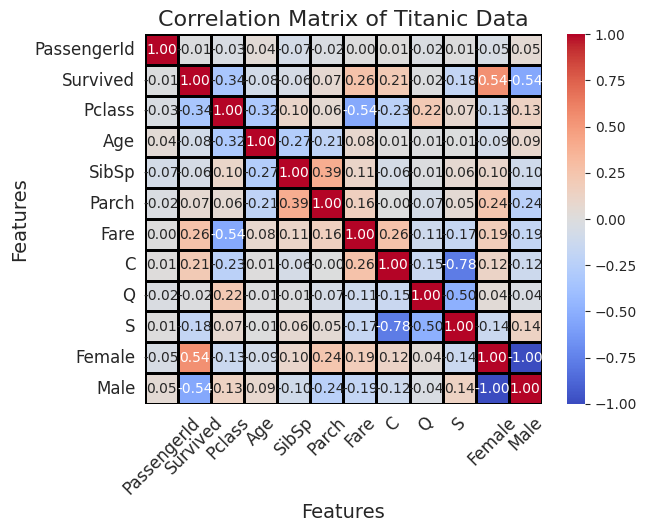

In [24]:
# Create heatmap with improved parameters
heatmap= sns.heatmap(strat_train_set.corr(), cmap="coolwarm", annot=True, fmt=".2f", linewidths=1, linecolor='black')
plt.title('Correlation Matrix of Titanic Data', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)
plt.show()

In [25]:
clf = RandomForestClassifier()

param_grid = [    
    {
        # Define a list of values for the number of trees
        "n_estimators": [10,100,200,500],
        # Define a list of values for the maximum depth of trees
        "max_depth": [None, 5, 10],
        # Define a list of values for the minimum number of samples required to split a node
        "min_samples_split": [2,3,4]
    }
]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy",return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [26]:
# Select the best estimator from the grid search results
final_clf = grid_search.best_estimator_
# Display the best estimator
final_clf

RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=10)

In [27]:
# Apply preprocessing pipeline to test set
strat_test_set = pipeline.fit_transform(strat_test_set)  
# Display preprocessed test set
strat_test_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,Q,S,Female,Male
363,364,0,3,35.000000,0,0,7.0500,0.0,0.0,1.0,0.0,1.0
595,596,0,3,36.000000,1,1,24.1500,0.0,0.0,1.0,0.0,1.0
288,289,1,2,42.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
560,561,0,3,31.178571,0,0,7.7500,0.0,1.0,0.0,0.0,1.0
127,128,1,3,24.000000,0,0,7.1417,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
416,417,1,2,34.000000,1,1,32.5000,0.0,0.0,1.0,1.0,0.0
152,153,0,3,55.500000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
496,497,1,1,54.000000,1,0,78.2667,1.0,0.0,0.0,1.0,0.0
142,143,1,3,24.000000,1,0,15.8500,0.0,0.0,1.0,1.0,0.0


In [28]:
# Extract features from preprocessed test set
X_test = strat_test_set.drop(["Survived"], axis=1)
# Extract target variable from preprocessed test set
y_test = strat_test_set["Survived"]

scaler = StandardScaler() 
# Standardize features
X_data_test = scaler.fit_transform(X_test)
# Convert target variable to NumPy array
y_data_test = y_test.to_numpy()

In [29]:
# Calculate the accuracy of the final classifier on the test set
final_clf.score(X_data_test, y_data_test)

0.8156424581005587

In [30]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
# Apply preprocessing pipeline to the entire dataset
final_data = pipeline.fit_transform(data)
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,Q,S,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [32]:
# Extract features from preprocessed dataset
X_final = final_data.drop(["Survived"], axis=1)  
# Extract target variable from preprocessed dataset
y_final = final_data["Survived"]  

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_test)
y_data_final = y_test.to_numpy()

In [33]:
prod_clf = RandomForestClassifier()
# Define hyperparameter grid for grid search
param_grid = [
    {
        "n_estimators": [10,100,200,500],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2,3,4]
    }
]

grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring="accuracy",return_train_score=True)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [34]:
# Select the best estimator from the grid search results
prod_final_clf = grid_search.best_estimator_
prod_final_clf

RandomForestClassifier(max_depth=5, n_estimators=500)

# Titanic - test dataset

In [35]:
titanic_test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
titanic_test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [36]:
# Apply preprocessing pipeline to the test dataset
final_test_data = pipeline.fit_transform(titanic_test_data)
final_test_data

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,Q,S,Female,Male
0,892,3,34.50000,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.00000,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.00000,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.00000,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.00000,1,1,12.2875,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
414,1306,1,39.00000,0,0,108.9000,1.0,0.0,0.0,1.0,0.0
415,1307,3,38.50000,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
416,1308,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [37]:
titanic_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  C            418 non-null    float64
 12  Q            418 non-null    float64
 13  S            418 non-null    float64
 14  Female       418 non-null    float64
 15  Male         418 non-null    float64
dtypes: float64(7), int64(4), object(5)
memory usage: 52.4+ KB


In [38]:
X_final_test = final_test_data
# Fill missing values using forward fill method
X_final_test = X_final_test.fillna(method="ffill")

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

/tmp/ipykernel_98/443079519.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method="ffill")


In [39]:
# Make predictions using the final classifier
predictions = prod_final_clf.predict(X_data_final_test)
predictions

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [40]:
# Create a DataFrame for PassengerId column
final_df = pd.DataFrame(titanic_test_data["PassengerId"])
# Add predictions to the DataFrame
final_df["Survived"] = predictions
# Save the predictions to a CSV file
final_df.to_csv("predictions.csv",index=False)
final_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
